
# Win Prediction — Transformer (MoE, 2025-style) + Calibration + Explicabilité complète

Objectif : un pipeline **robuste et explicable** pour prédire la win (`R∈{-1,1}` → {0,1}), en tirant parti d'un **Transformer tabulaire séquentiel** avec **Mixture-of-Experts (Top-2)**, **calibration** (Platt), et un panel clair d'explications : **Integrated Gradients (global/local)**, **SHAP Kernel** (global), **LIME** (local), **PDP/ICE**, **attentions**.  
On trace aussi : courbes d'apprentissage, calibration, *backtest* temporel, **prédictions historiques vs réelles**, et **20 scénarios futurs** exportés.

> Conçu pour tourner en CPU ; décommentez les installations si nécessaire.


## (Optionnel) Installations

In [909]:

# %pip install -q pandas numpy scikit-learn matplotlib torch shap lime


## Imports & configuration

In [910]:

import os, math, json, random, warnings, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

import torch
import torch.nn as nn
import torch.nn.functional as _F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")
np.random.seed(42); random.seed(42); torch.manual_seed(42)
DEVICE = torch.device("cpu")
print("Torch device:", DEVICE)


Torch device: cpu


## Chargement des données (Google Sheet + fallback CSV)

In [911]:

SHEET_ID = "1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y"
GID = "1517184233"
DATA_PATH = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={GID}"
FALLBACK = "TEAM DIFF  @10 MIN - New.csv"  # placez ce fichier à côté du notebook si besoin

def load_df():
    try:
        df = pd.read_csv(DATA_PATH).dropna(axis=1, how="all")
        print("Loaded from Google Sheet")
        return df
    except Exception as e:
        print("Google Sheet failed, fallback:", e)
        if os.path.exists(FALLBACK):
            return pd.read_csv(FALLBACK)
        raise

df = load_df().replace({"-": np.nan})
print("Shape raw:", df.shape)


Loaded from Google Sheet
Shape raw: (107, 8)


## Feature engineering cohérent avec ton cadre

In [912]:

CANDS = {
    "label": ["R","result","win","label","target"],
    "gap": ["Team Gap Early","team gap early","team_diff","team_gap","teamgap"],
    "rel": ["Perf relative","relative_perf","rel_perf","perf_relative","relative"],
    "intr": ["Perf intrinsèque","intrinsic_perf","intrinsic_skill","perf_intrinseque","intrinsic"],
    "time": ["timestamp","time","date","match_time"]
}

def pick_name(df, keys):
    cols = list(df.columns)
    for k in keys:
        for c in cols:
            if c.lower().strip()==k.lower().strip(): return c
    for k in keys:
        for c in cols:
            if k.lower().strip() in c.lower().strip(): return c
    return None

label_col = pick_name(df, CANDS["label"])
gap_col   = pick_name(df, CANDS["gap"])
rel_col   = pick_name(df, CANDS["rel"])
intr_col  = pick_name(df, CANDS["intr"])
time_col  = pick_name(df, CANDS["time"])

assert label_col and gap_col, "R et Team Gap Early requis"
for c in [label_col, gap_col, rel_col, intr_col]:
    if c and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Label {-1,1} -> {0,1}
df = df.dropna(subset=[label_col, gap_col]).copy()
df[label_col] = df[label_col].map({-1:0, 1:1}).fillna(df[label_col]).astype(int)
# Gap borné
df[gap_col] = df[gap_col].clip(-2,2).fillna(0.0)

# Perf relative
if rel_col is None:
    rel_col = "Perf relative (fallback)"
    df[rel_col] = 0.0
else:
    df[rel_col] = df[rel_col].fillna(0.0)

# Perf intrinsèque (fallback EMA relative)
if intr_col and intr_col in df.columns:
    df["intrinsic_skill"] = pd.to_numeric(df[intr_col], errors="coerce").fillna(0.0)
else:
    s = df[rel_col].fillna(0.0)
    df["intrinsic_skill"] = s.ewm(alpha=0.2, adjust=False).mean().shift(1).fillna(s.median())

# Lose streak sur gap négatif
streak=0; ls=[]
for g in df[gap_col].values:
    if g<0: streak+=1
    else: streak=0
    ls.append(streak)
df["lose_streak"] = ls

# Interactions
df["gap_x_rel"] = df[gap_col]*df[rel_col]
df["rel_sq"] = df[rel_col]**2
df["skill_sq"] = df["intrinsic_skill"]**2

FEATURES_BASE = [gap_col, rel_col, "intrinsic_skill", "lose_streak", "gap_x_rel", "rel_sq", "skill_sq"]
print("Features:", FEATURES_BASE)

df.head(60)


Features: ['Team Gap Early', 'Perf relative', 'intrinsic_skill', 'lose_streak', 'gap_x_rel', 'rel_sq', 'skill_sq']


,% / Rela,% / Intra,Pred_TeamGapEarly_Next,Team Gap Early,R,Perf relative,Perf intrinsèque,Unnamed: 9,intrinsic_skill,lose_streak,gap_x_rel,rel_sq,skill_sq
0,NaN,NaN,NaN,0.0,1,-2.0,0.0,NaN,0.0,0,-0.0,4.0,0.0
1,NaN,NaN,NaN,-1.0,0,-2.0,0.0,NaN,0.0,1,2.0,4.0,0.0
2,NaN,NaN,NaN,2.0,1,-1.0,2.0,NaN,2.0,0,-2.0,1.0,4.0
3,NaN,NaN,NaN,-1.0,1,-1.0,0.0,NaN,0.0,1,1.0,1.0,0.0
4,NaN,NaN,NaN,-1.0,0,2.0,0.0,- Un mec run down : \nGarder son calme et joue...,0.0,2,-2.0,4.0,0.0
5,NaN,NaN,NaN,-2.0,0,2.0,1.0,NaN,1.0,3,-4.0,4.0,1.0
6,NaN,NaN,NaN,1.0,1,-2.0,-2.0,NaN,-2.0,0,-2.0,4.0,4.0
7,58,52,52,-2.0,0,2.0,1.0,NaN,1.0,1,-4.0,4.0,1.0
8,79,67,67,2.0,1,-2.0,-1.0,NaN,-1.0,0,-4.0,4.0,1.0
9,48,44,44,-2.0,0,1.0,-2.0,NaN,-2.0,1,-2.0,1.0,4.0


## Construction séquentielle (fenêtrage)

In [913]:
# === Séquençage robuste + split temporel par index-cible + scaling 3D robuste ===
from sklearn.preprocessing import StandardScaler
import numpy as np

WIN = 6
FEATS = FEATURES_BASE
F = len(FEATS)

# 1) construire TOUTES les séquences d'abord
vals = df[FEATS].values.astype(np.float32)
labs = df[label_col].values.astype(np.int64)
N_raw = len(df)

X_all, y_all, t_idx = [], [], []
for i in range(WIN, N_raw):
    X_all.append(vals[i-WIN:i, :])         # (WIN,F)
    y_all.append(labs[i])                  # 0/1
    t_idx.append(i)                        # index absolu de la cible

if len(X_all) == 0:
    raise ValueError(f"Aucune séquence. Augmente les données ou baisse WIN (actuel={WIN}).")

X_all = np.stack(X_all, axis=0).astype(np.float32)  # (N_seq,WIN,F)
y_all = np.asarray(y_all, dtype=np.int64)
t_idx = np.asarray(t_idx, dtype=int)

# 2) split chrono par l'index de la cible
cut  = int(0.70 * N_raw)
cut2 = int(0.85 * N_raw)
m_tr = t_idx < cut
m_va = (t_idx >= cut) & (t_idx < cut2)
m_te = t_idx >= cut2

Xtr, ytr = X_all[m_tr], y_all[m_tr]
Xva, yva = X_all[m_va], y_all[m_va]
Xte, yte = X_all[m_te], y_all[m_te]

print("Seq shapes (avant scaling):", Xtr.shape, Xva.shape, Xte.shape)

# 3) si val/test vides, on prélève au bout du train pour éviter tout crash
def siphon_from_train(Xtr, ytr, take_ratio=0.15, min_take=1):
    if len(Xtr) <= 1: 
        return Xtr, ytr, Xtr[:0], ytr[:0]
    take = max(min_take, int(take_ratio * len(Xtr)))
    take = min(take, len(Xtr)-1)
    return (Xtr[:-take], ytr[:-take], Xtr[-take:], ytr[-take:])

if Xva.shape[0] == 0 and Xtr.shape[0] >= 2:
    Xtr, ytr, Xva, yva = siphon_from_train(Xtr, ytr, take_ratio=0.15)
    print(f"Val vide → prélèvement {len(Xva)} séq depuis la fin du train.")
if Xte.shape[0] == 0 and Xtr.shape[0] >= 2:
    Xtr, ytr, Xte, yte = siphon_from_train(Xtr, ytr, take_ratio=0.15)
    print(f"Test vide → prélèvement {len(Xte)} séq depuis la fin du train.")

# 4) scaling 3D : fit sur (N_train*T,1) par feature, transform idem
scalers = []
for j in range(F):
    sc = StandardScaler()
    sc.fit(Xtr[:, :, j].reshape(-1, 1))
    scalers.append(sc)

def transform3d(X, scalers):
    if X.ndim != 3 or X.shape[0] == 0:
        return X
    N, T, F_ = X.shape
    Z = X.copy()
    for j, sc in enumerate(scalers):
        Z[:, :, j] = sc.transform(Z[:, :, j].reshape(-1, 1)).reshape(N, T)
    return Z

Xtrn = transform3d(Xtr, scalers)
Xvan = transform3d(Xva, scalers)
Xten = transform3d(Xte, scalers)

print("Seq shapes (après scaling):", Xtrn.shape, Xvan.shape, Xten.shape, "| y_train mean:", ytr.mean() if ytr.size else "NA")


Seq shapes (avant scaling): (33, 6, 7) (9, 6, 7) (9, 6, 7)
Seq shapes (après scaling): (33, 6, 7) (9, 6, 7) (9, 6, 7) | y_train mean: 0.5757575757575758


## Modèle Transformer Tabulaire séquentiel + MoE (Top-2)

In [914]:

class ExpertMLP(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.fc1 = nn.Linear(d, h)
        self.fc2 = nn.Linear(h, d)
    def forward(self, x):
        return self.fc2(_F.silu(self.fc1(x)))

class Top2MoE(nn.Module):
    def __init__(self, d_model, n_experts=4, hidden=64):
        super().__init__()
        self.experts = nn.ModuleList([ExpertMLP(d_model, hidden) for _ in range(n_experts)])
        self.gate = nn.Linear(d_model, n_experts)
        self.n_experts = n_experts
    def forward(self, x):
        # x: [B,T,D]
        B,T,D = x.shape
        g = self.gate(x)                 # [B,T,E]
        w = _F.softmax(g, dim=-1)         # probs
        top2_w, top2_i = torch.topk(w, k=min(2, self.n_experts), dim=-1)  # [B,T,2]
        out = torch.zeros_like(x)
        aux = w.mean(dim=(0,1))          # for load balance monitoring
        for k in range(top2_w.shape[-1]):
            idx = top2_i[...,k]          # [B,T]
            wk  = top2_w[...,k].unsqueeze(-1) # [B,T,1]
            # gather per-position expert
            y = torch.zeros_like(x)
            for e in range(self.n_experts):
                mask = (idx==e).unsqueeze(-1) # [B,T,1]
                if mask.any():
                    y = y + torch.where(mask, self.experts[e](x), torch.zeros_like(x))
            out = out + wk * y
        return out, aux

class Block(nn.Module):
    def __init__(self, d_model, nhead, n_experts=4, moe_hidden=64, p=0.1, p_attn=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=p_attn)
        self.ln1 = nn.LayerNorm(d_model)
        self.moe = Top2MoE(d_model, n_experts=n_experts, hidden=moe_hidden)
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(p)
    def forward(self, x, attn_mask=None):
        h, w = self.attn(
            x, x, x,
            attn_mask=attn_mask,
            need_weights=True,
            average_attn_weights=False  # <- IMPORTANT : on garde les têtes
        )
        x = self.ln1(x + self.drop(h))
        y, aux = self.moe(x)
        x = self.ln2(x + self.drop(y))
        return x, w, aux

class TabTransformerMoE(nn.Module):
    def __init__(self, d_in, d_model=64, depth=3, nhead=4, n_experts=4, moe_hidden=64, p=0.1, p_attn=0.1):
        super().__init__()
        self.proj = nn.Linear(d_in, d_model)
        self.blocks = nn.ModuleList([Block(d_model, nhead, n_experts, moe_hidden, p, p_attn) for _ in range(depth)])
        self.head = nn.Linear(d_model, 1)  # CLS-like: mean pooling
    def forward(self, x):
        # x: [B,T,D_in]
        z = self.proj(x)
        attn_ws = []
        auxs = []
        for blk in self.blocks:
            z, w, aux = blk(z, attn_mask=None)
            attn_ws.append(w)   # [B,nhead,T,T]
            auxs.append(aux)    # [E] mean usage
        pooled = z.mean(dim=1)  # mean over time
        logit = self.head(pooled).squeeze(-1)
        return logit, attn_ws, auxs


## Entraînement : AdamW + early stopping (logloss) + OneCycleLR

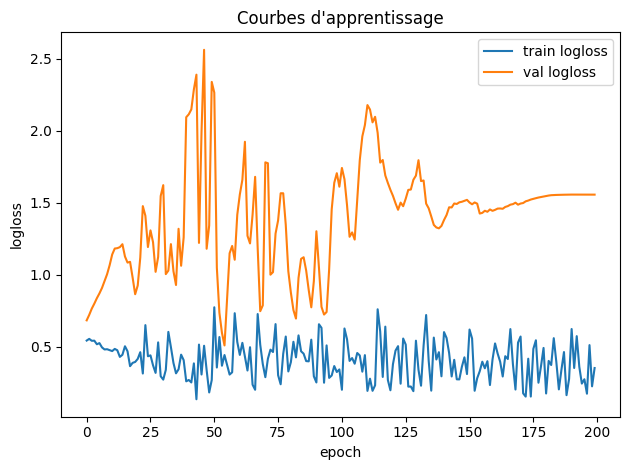

In [ ]:

class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

def train_model_old(Xtr, ytr, Xva, yva, epochs=100, bs=128, lr=3e-5, wd=1e-4, patience=20):
    tr_dl = DataLoader(SeqDS(Xtr,ytr), batch_size=bs, shuffle=True)
    va_dl = DataLoader(SeqDS(Xva,yva), batch_size=bs, shuffle=False)
    model = TabTransformerMoE(d_in=Xtr.shape[-1], d_model=128, depth=3, nhead=16, n_experts=12, moe_hidden=192, p=0.5, p_attn=0.5).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sch = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(tr_dl), epochs=epochs)
    best=float("inf"); bad=0; best_state=None
    hist={"train_ll":[], "val_ll":[]}
    for ep in range(epochs):
        model.train(); s=0; n=0
        for xb,yb in tr_dl:
            xb,yb=xb.to(DEVICE), yb.to(DEVICE)
            logit,_,_ = model(xb)
            loss = _F.binary_cross_entropy_with_logits(logit, yb)
            opt.zero_grad(); loss.backward(); opt.step(); sch.step()
            s += loss.item()*xb.size(0); n += xb.size(0)
        train_ll = s/n
        # val
        model.eval(); s=0; n=0
        with torch.no_grad():
            for xb,yb in va_dl:
                xb,yb=xb.to(DEVICE), yb.to(DEVICE)
                logit,_,_ = model(xb)
                p = torch.sigmoid(logit)
                loss = _F.binary_cross_entropy(p, yb)
                s += loss.item()*xb.size(0); n += xb.size(0)
        val_ll = s/n
        hist["train_ll"].append(train_ll); hist["val_ll"].append(val_ll)
        if val_ll < best-1e-5:
            best, bad, best_state = val_ll, 0, {k:v.cpu().clone() for k,v in model.state_dict().items()}
        else:
            bad += 1
        # if bad>=patience: break
    model.load_state_dict(best_state)
    model.eval()
    return model, hist

def train_model(
    Xtr, ytr, Xva, yva,
    epochs=80, bs=64, lr=3e-3, wd=5e-4, patience=12,
    d_model=64, depth=2, nhead=4, n_experts=4, moe_hidden=96, p=0.2, p_attn=0.1,
    mixup_alpha=0.2, time_mask_prob=0.5, time_mask_frac=0.2, lambda_aux=0.01, grad_clip=1.0
):
    tr_dl = DataLoader(SeqDS(Xtr,ytr), batch_size=bs, shuffle=True)
    va_dl = DataLoader(SeqDS(Xva,yva), batch_size=bs, shuffle=False)

    model = TabTransformerMoE(
        d_in=Xtr.shape[-1], d_model=d_model, depth=depth, nhead=nhead,
        n_experts=n_experts, moe_hidden=moe_hidden, p=p, p_attn=p_attn
    ).to(DEVICE)

    # pos_weight (si classes déséquilibrées)
    pos_rate = float(ytr.mean()) if len(ytr) else 0.5
    if 0.0 < pos_rate < 1.0:
        pos_w = torch.tensor([(1.0-pos_rate)/max(pos_rate,1e-6)], dtype=torch.float32, device=DEVICE)
        bce = nn.BCEWithLogitsLoss(pos_weight=pos_w)
    else:
        bce = nn.BCEWithLogitsLoss()

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sch = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=max(1,len(tr_dl)), epochs=epochs)

    def do_mixup(x, y):
        if mixup_alpha <= 0: return x, y
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        perm = torch.randperm(x.size(0), device=x.device)
        x = lam*x + (1-lam)*x[perm]
        y = lam*y + (1-lam)*y[perm]
        return x, y

    def time_mask(x):
        if time_mask_prob <= 0 or np.random.rand()>time_mask_prob: return x
        B,T,D = x.shape
        L = max(1, int(time_mask_frac*T))
        s = np.random.randint(0, T-L+1)
        xm = x.clone()
        xm[:, s:s+L, :] = 0.0
        return xm

    best=float("inf"); bad=0; best_state=None
    hist={"train_ll":[], "val_ll":[]}

    for ep in range(epochs):
        model.train(); s=0; n=0
        for xb,yb in tr_dl:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE).view(-1)
            xb = time_mask(xb)
            xb, yb = do_mixup(xb, yb)

            logit, attn_ws, auxs = model(xb)        # auxs: liste de [E] (par bloc)
            loss = bce(logit, yb)

            # Aux loss MoE: KL(moyenne gate || uniforme)
            if auxs:
                kl = 0.0
                for aux in auxs:    # aux ~ moyenne des w sur (B,T)
                    p_gate = aux / (aux.sum()+1e-9)             # (E,)
                    u = torch.full_like(p_gate, 1.0/len(p_gate))
                    kl += torch.sum(p_gate * (p_gate.add(1e-9).log() - u.log()))
                loss = loss + lambda_aux * kl

            opt.zero_grad()
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step(); sch.step()
            s += loss.item()*xb.size(0); n += xb.size(0)
        train_ll = s/n

        # Validation (sans mixup/masque)
        model.eval(); s=0; n=0
        with torch.no_grad():
            for xb,yb in va_dl:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE).view(-1)
                logit, *_ = model(xb)
                s += bce(logit, yb).item()*xb.size(0); n += xb.size(0)
        val_ll = s/n

        hist["train_ll"].append(train_ll); hist["val_ll"].append(val_ll)
        if val_ll < best - 1e-5:
            best, bad, best_state = val_ll, 0, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            bad += 1
        if bad >= patience: break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    return model, hist


# model, hist = train_model(Xtrn, ytr, Xvan, yva)
model, hist = train_model(
    Xtrn, ytr, Xvan, yva,
    epochs=200, bs=128, lr=3e-3, wd=2e-3, patience=200,
    d_model=256, depth=2, nhead=8, n_experts=12, moe_hidden=384, p=0.35, p_attn=0.25,
    mixup_alpha=0.35, time_mask_prob=0.5, time_mask_frac=0.2, lambda_aux=0.1, grad_clip=1.0
)
plt.figure()
plt.plot(hist["train_ll"], label="train logloss")
plt.plot(hist["val_ll"], label="val logloss")
plt.xlabel("epoch"); plt.ylabel("logloss"); plt.title("Courbes d'apprentissage")
plt.legend(); plt.tight_layout(); plt.show()


## Calibration (Platt) + Évaluations complètes + tracés

Platt: a=0.5924 b=-0.5334
Train  AUC=0.9624  PR=0.9769  LogLoss=0.4200  Brier=0.1305  Acc=0.8485
Valid  AUC=0.7778  PR=0.7000  LogLoss=0.5455  Brier=0.1854  Acc=0.7778
Test   AUC=0.6500  PR=0.7295  LogLoss=1.1694  Brier=0.4157  Acc=0.4444


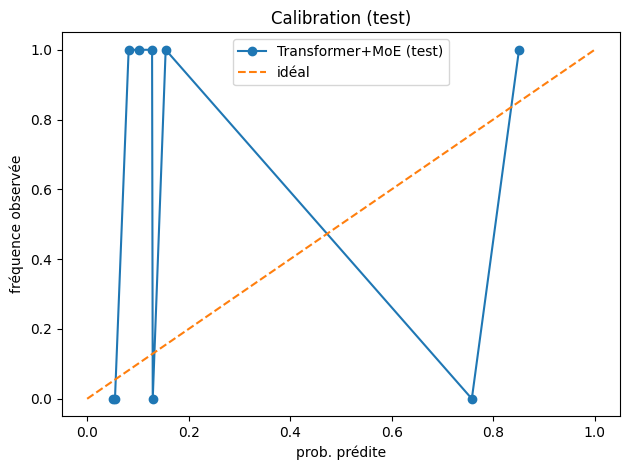

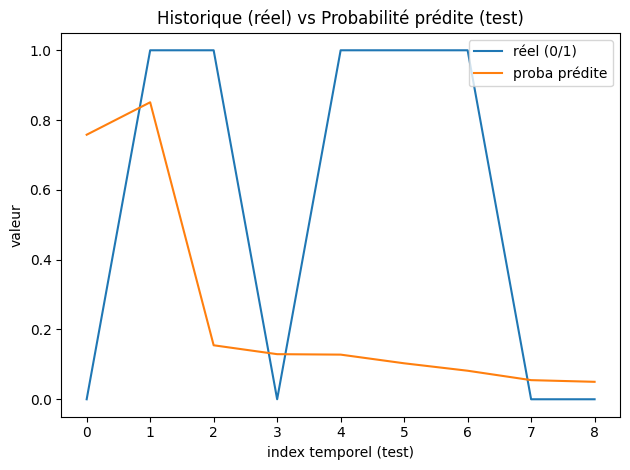

In [916]:

@torch.no_grad()
def logits_on(X):
    z,_,_ = model(torch.tensor(X, dtype=torch.float32).to(DEVICE))
    return z.cpu().numpy()

z_tr = logits_on(Xtrn); z_va = logits_on(Xvan); z_te = logits_on(Xten)

# Platt on validation
ab = torch.nn.Parameter(torch.tensor([1.0, 0.0], dtype=torch.float32))
opt = torch.optim.LBFGS([ab], lr=0.5, max_iter=200, line_search_fn="strong_wolfe")
zv = torch.tensor(z_va, dtype=torch.float32)
yv = torch.tensor(yva, dtype=torch.float32).view(-1,1)
def nll():
    opt.zero_grad()
    a,b = ab[0], ab[1]
    p = torch.sigmoid(a*zv + b).view(-1,1)
    loss = _F.binary_cross_entropy(p, yv)
    loss.backward(); return loss
opt.step(nll); a,b = ab.detach().numpy().tolist()
print("Platt: a=%.4f b=%.4f" % (a,b))

def proba(X):
    z = logits_on(X)
    p = 1/(1+np.exp(-(a*z + b)))
    return np.clip(p, 1e-6, 1-1e-6)

for name,(X,y) in {"Train":(Xtrn,ytr),"Valid":(Xvan,yva),"Test":(Xten,yte)}.items():
    p = proba(X)
    auc = roc_auc_score(y, p); pr = average_precision_score(y, p)
    ll  = log_loss(y, p); br = brier_score_loss(y, p)
    acc = accuracy_score(y, (p>=0.5).astype(int))
    print(f"{name:5s}  AUC={auc:.4f}  PR={pr:.4f}  LogLoss={ll:.4f}  Brier={br:.4f}  Acc={acc:.4f}")

# Calibration curve (test)
pt, pp = calibration_curve(yte, proba(Xten), n_bins=10, strategy="quantile")
plt.figure()
plt.plot(pp, pt, "o-", label="Transformer+MoE (test)")
plt.plot([0,1],[0,1],"--", label="idéal")
plt.xlabel("prob. prédite"); plt.ylabel("fréquence observée"); plt.title("Calibration (test)")
plt.legend(); plt.tight_layout(); plt.show()

# Historique vs proba prédite (sur test)
plt.figure()
plt.plot(range(len(yte)), yte, label="réel (0/1)")
plt.plot(range(len(yte)), proba(Xten), label="proba prédite")
plt.xlabel("index temporel (test)"); plt.ylabel("valeur")
plt.title("Historique (réel) vs Probabilité prédite (test)")
plt.legend(); plt.tight_layout(); plt.show()


## Attentions & usage des experts (diagnostic)

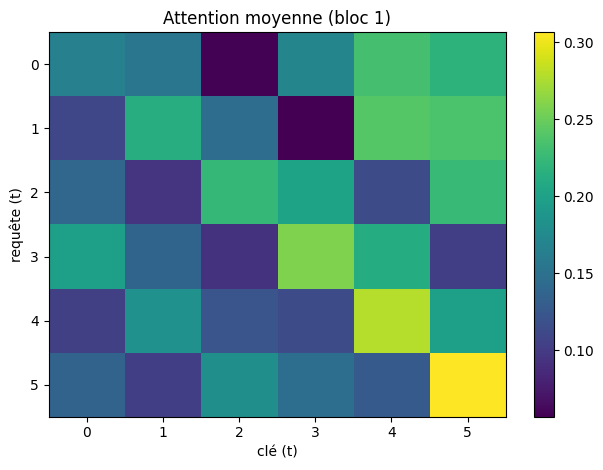

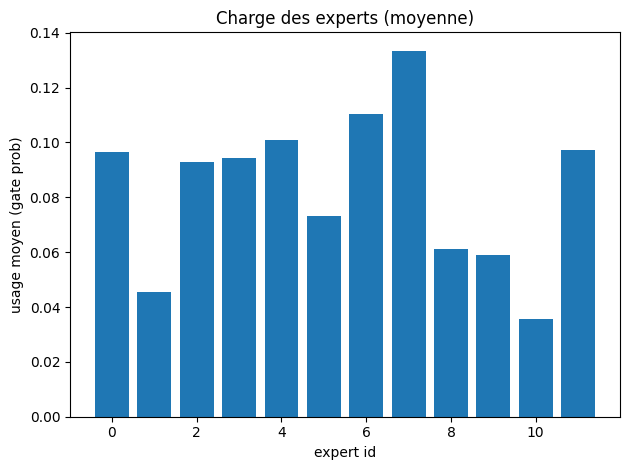

In [917]:

# Exemple: un batch test pour extraire attentions et l'utilisation moyenne des experts
with torch.no_grad():
    xb = torch.tensor(Xten[:64], dtype=torch.float32).to(DEVICE)
    z = model.proj(xb)
    attn_ws = []
    auxs = []
    h = z
    for blk in model.blocks:
        h2,w,aux = blk(h)
        attn_ws.append(w)   # [B, nhead, T, T]
        auxs.append(aux)    # [E]
        h = h2

# Heatmap attention moyenne premier bloc/tête
W = attn_ws[0].mean(dim=(0,1)).cpu().numpy()  # [T,T]
plt.figure()
plt.imshow(W, aspect="auto")
plt.colorbar(); plt.title("Attention moyenne (bloc 1)")
plt.xlabel("clé (t)"); plt.ylabel("requête (t)")
plt.tight_layout(); plt.show()

# Usage moyen des experts (moyenne blocs)
U = torch.stack([a for a in auxs]).mean(dim=0).cpu().numpy()
plt.figure()
plt.bar(range(len(U)), U)
plt.xlabel("expert id"); plt.ylabel("usage moyen (gate prob)")
plt.title("Charge des experts (moyenne)")
plt.tight_layout(); plt.show()


## Integrated Gradients (global & local)

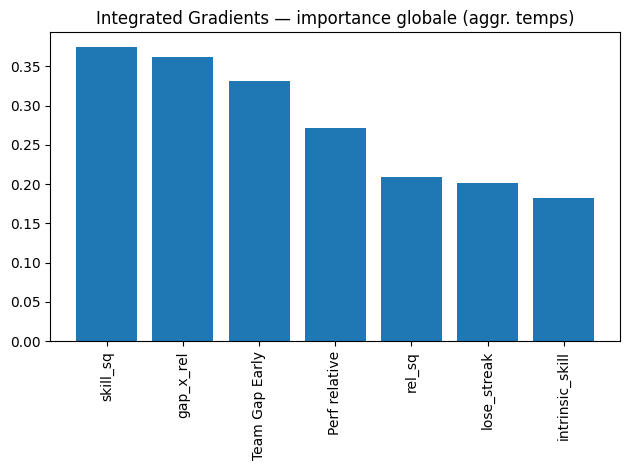

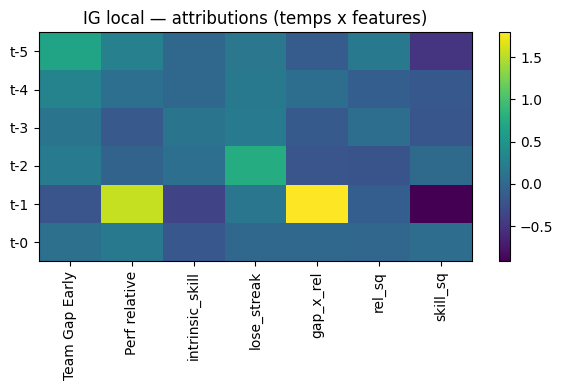

In [918]:

def integrated_gradients(model, x, steps=64, baseline=None, use_prob=False):
    """
    Calcule les Integrated Gradients pour un batch x: [B,T,D].
    - use_prob=False -> gradient du logit (recommandé si tu entraînes avec BCEWithLogitsLoss)
    - use_prob=True  -> gradient de la probabilité sigmoid(logit)
    Retour: attrs [B,T,D]
    """
    model.eval()  # désactive dropout, etc.
    
    # Tensor + device
    x = torch.as_tensor(x, dtype=torch.float32, device=DEVICE)
    if baseline is None:
        baseline = torch.zeros_like(x)

    total = torch.zeros_like(x)

    for k in range(1, steps + 1):
        alpha = float(k) / steps
        xk = baseline + alpha * (x - baseline)   # pas leaf -> on évite .grad
        xk.requires_grad_(True)                  # on s'assure que l'autograd suit xk

        logit, *_ = model(xk)                    # [B]
        out = torch.sigmoid(logit) if use_prob else logit

        # grad wrt xk (scalaire -> on somme les sorties pour avoir un scalaire)
        grads = torch.autograd.grad(outputs=out.sum(), inputs=xk, retain_graph=False)[0]
        total = total + grads

        # (optionnel) pour être clean :
        model.zero_grad(set_to_none=True)

    attrs = (x - baseline) * total / steps
    return attrs.detach().cpu().numpy()


# Global importance = moyenne des |attributions| agrégées sur (temps, batch)
idx = np.random.RandomState(0).choice(len(Xten), size=min(128,len(Xten)), replace=False)
A = integrated_gradients(model, Xten[idx], steps=64)   # [B,T,D]
G = np.mean(np.abs(A), axis=(0,1))                     # [D]
order = np.argsort(-G)
plt.figure()
plt.bar(range(len(G)), G[order])
plt.xticks(range(len(G)), np.array(FEATS)[order], rotation=90)
plt.title("Integrated Gradients — importance globale (aggr. temps)")
plt.tight_layout(); plt.show()

# Local (premier item test) — heatmap temps x features
L = integrated_gradients(model, Xten[0:1], steps=128)[0]  # [T,D]
plt.figure(figsize=(6,4))
plt.imshow(L, aspect="auto")
plt.xticks(range(len(FEATS)), FEATS, rotation=90)
plt.yticks(range(L.shape[0]), [f"t-{L.shape[0]-1-i}" for i in range(L.shape[0])])
plt.colorbar(); plt.title("IG local — attributions (temps x features)")
plt.tight_layout(); plt.show()


## LIME (local) & SHAP Kernel (global) — optionnels

In [919]:
def scale_flat_2d(X2D):
    """X2D: (N,D). Applique les 'scalers' colonne par colonne correctement (2D attendu)."""
    X = np.asarray(X2D, dtype=np.float32).copy()
    for j, sc in enumerate(scalers):
        X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()
    return X

def to_seq_from_flat(X2D):
    """Répète chaque vecteur (N,D) sur WIN pas de temps -> (N,WIN,D)."""
    X = scale_flat_2d(X2D)
    return np.repeat(X[:, None, :], WIN, axis=1)

@torch.no_grad()
def logits_on_seq(Xseq):
    """Xseq: numpy (B,T,D). Retourne logits (B,)."""
    x = torch.from_numpy(Xseq.astype(np.float32)).to(DEVICE)
    logit, *_ = model(x)
    return logit.detach().cpu().numpy()

def logits_on_flat(X2D):
    """Interface modèle tabulaire 2D -> logits, en passant par la séquence."""
    Xseq = to_seq_from_flat(X2D)
    return logits_on_seq(Xseq)

def proba_on_flat_2cols(X2D):
    """Retourne proba classe 0/1 au format (N,2) pour LIME."""
    z = logits_on_flat(X2D)
    try:
        p = 1 / (1 + np.exp(-(a * z + b)))  # calibré si tu as a,b
    except NameError:
        p = 1 / (1 + np.exp(-z))            # sinon sigmoid
    return np.c_[1 - p, p]

def proba1_on_flat(X2D):
    """Retourne proba classe 1 au format (N,) pour SHAP."""
    return proba_on_flat_2cols(X2D)[:, 1]


In [920]:

def predict_proba_df(Xdf):
    X = Xdf[FEATS].values.astype(np.float32)
    # normaliser avec nos scalers
    for j,sc in enumerate(scalers):
        X[:,j] = sc.transform(X[:,j])
    # créer séquences en répliquant la ligne (fenêtre pleine avec dernière ligne)
    Xseq = np.repeat(X[np.newaxis, :], WIN, axis=0).transpose(1,0,2)  # [N,T,D]
    p = 1/(1+np.exp(-(a*logits_on(Xseq) + b)))
    return np.vstack([1-p, p]).T

# LIME
try:
    from lime.lime_tabular import LimeTabularExplainer

    # Base tabulaire (2D) sur tes features
    base = df[FEATS].fillna(0.0).astype(np.float32)

    explainer = LimeTabularExplainer(
        training_data=base.values,
        feature_names=FEATS,
        class_names=["lose","win"],
        mode="classification",
        discretize_continuous=True
    )

    i = 0  # exemple à expliquer
    x0 = base.iloc[i].values.astype(np.float32)

    # IMPORTANT: passer une fonction qui prend (N,D) et renvoie (N,2)
    exp = explainer.explain_instance(
        data_row=x0,
        predict_fn=proba_on_flat_2cols,
        num_features=min(10, len(FEATS)),
        top_labels=1
    )

    print("LIME (sample", i, ") – top contributions:")
    for name, val in exp.as_list(label=1):
        print(f"{name:20s} {val:+.4f}")

except Exception as e:
    print("LIME indisponible:", e)

# SHAP Kernel
try:
    import shap
    # Background (2D)
    bg_idx = np.random.RandomState(0).choice(len(base), size=min(100, len(base)), replace=False)
    bg = base.iloc[bg_idx].values.astype(np.float32)

    # f(x) doit accepter (N,D) et renvoyer (N,) => proba classe 1
    f_shap = proba1_on_flat

    expl = shap.KernelExplainer(f_shap, bg)
    x1 = x0.reshape(1, -1)
    sv = expl.shap_values(x1, nsamples=200)  # (1,D)

    print("SHAP (sample", i, ") – top contributions:")
    pairs = list(zip(FEATS, sv[0]))
    for name, val in sorted(pairs, key=lambda t: -abs(t[1]))[:10]:
        print(f"{name:20s} {val:+.4f}")

except Exception as e:
    print("SHAP indisponible:", e)


LIME (sample 0 ) – top contributions:
LIME indisponible: 1


100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

SHAP (sample 0 ) – top contributions:
Perf relative        -0.1753
Team Gap Early       -0.0330
skill_sq             +0.0312
gap_x_rel            +0.0225
intrinsic_skill      -0.0188
lose_streak          -0.0032
rel_sq               +0.0003


## PDP & ICE (dernière étape temporelle)

Text(0, 0.5, 'P(win)')

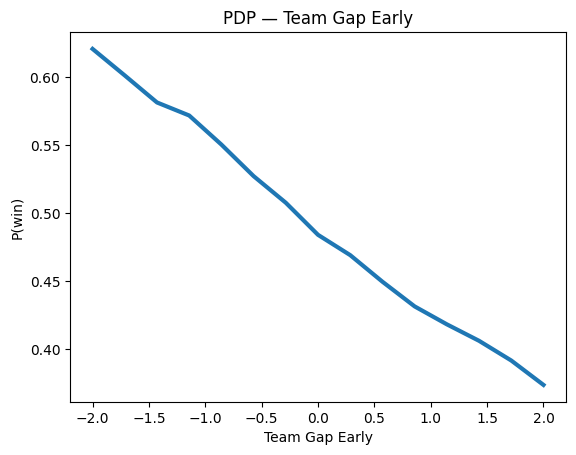

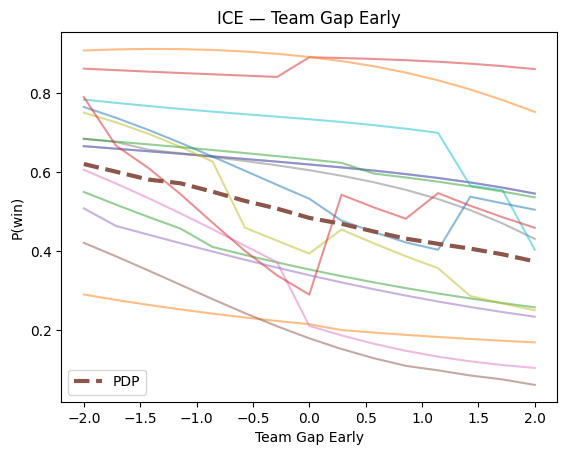

In [921]:

def pdp_1d(base_df, feat_name, grid_vals):
    """PDP 1D sur une feature en gardant les autres fixes à base_df (2D), 
       et en répétant sur le temps (WIN). Retourne proba moyenne par grid."""
    Xtmp = base_df.copy()
    out = []
    for v in grid_vals:
        Xtmp[feat_name] = v
        X = Xtmp[FEATS].values.astype(np.float32)
        # scaling par colonne (2D attendu)
        for j, sc in enumerate(scalers):
            X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()
        # répéter sur le temps
        Xseq = np.repeat(X[:, None, :], WIN, axis=1)
        # proba calibrée si dispo
        z = logits_on_seq(Xseq)
        try:
            p = 1 / (1 + np.exp(-(a * z + b)))
        except NameError:
            p = 1 / (1 + np.exp(-z))
        out.append(p.mean())
    return np.array(out)

def ice_1d(base_df, feat_name, grid_vals, n_curves=20, seed=0):
    """ICE 1D: on trace n_curves lignes (échantillons) vs grid."""
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(base_df), size=min(n_curves, len(base_df)), replace=False)
    curves = []
    for i in idx:
        row = base_df.iloc[[i]].copy()    # DataFrame (1,D)
        vals = []
        for v in grid_vals:
            row[feat_name] = v
            X = row[FEATS].values.astype(np.float32)  # (1,D)
            for j, sc in enumerate(scalers):
                X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()
            Xseq = np.repeat(X[:, None, :], WIN, axis=1)
            z = logits_on_seq(Xseq)
            try:
                p = 1 / (1 + np.exp(-(a * z + b)))
            except NameError:
                p = 1 / (1 + np.exp(-z))
            vals.append(float(p[0]))
        curves.append(vals)
    return np.array(curves)  # (n_curves, len(grid_vals))


f = FEATS[0]  # feature étudiée
q = np.quantile(base[f], [0.05, 0.25, 0.5, 0.75, 0.95])
grid = np.linspace(q[0], q[-1], 15)

P = pdp_1d(base, f, grid)
C = ice_1d(base, f, grid, n_curves=15)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(grid, P, lw=3); plt.title(f"PDP — {f}")
plt.xlabel(f); plt.ylabel("P(win)")

plt.figure()
for k in range(C.shape[0]):
    plt.plot(grid, C[k], alpha=0.5)
plt.plot(grid, P, lw=3, linestyle="--", label="PDP")
plt.legend(); plt.title(f"ICE — {f}")
plt.xlabel(f); plt.ylabel("P(win)")



## Prédictions historiques vs modèle + 20 prédictions futures exportées

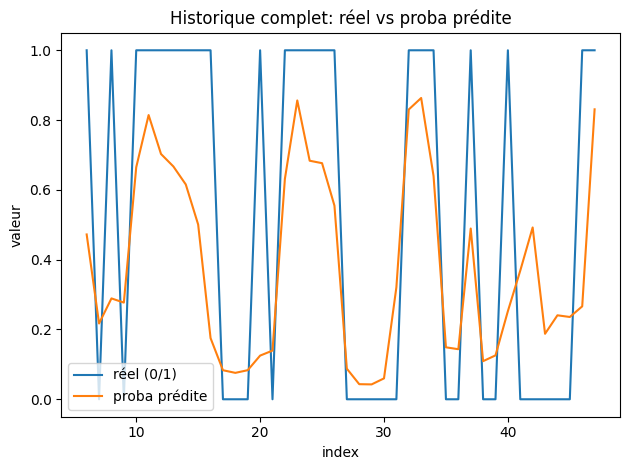

Écrit: future_predictions_transformer_moe.csv


,scenario_id,Team Gap Early,Perf relative,intrinsic_skill,lose_streak,gap_x_rel,rel_sq,skill_sq,pred_win_proba
0,1,-0.905791,0.676182,2.196808,1.264968,-1.961686,0.579259,4.043543,52.150002
1,2,-1.097772,0.994769,1.776287,1.247737,-0.616618,1.021335,4.383942,54.119999
2,3,-0.855461,0.732443,2.096706,0.729871,-0.567002,0.983869,3.937035,53.820000
3,4,-1.210522,1.380661,1.959474,0.879335,-1.173570,1.171992,4.124471,57.259998
4,5,-0.872396,1.134144,2.561653,0.885508,-1.252490,0.737066,4.209805,51.259998
5,6,-0.650957,0.964520,1.779667,0.767734,-0.679316,1.240150,4.185000,53.389999
6,7,-1.205755,1.072288,2.030601,1.061607,-0.570463,1.072245,4.231240,55.380001
7,8,-0.979107,1.090023,2.165557,0.589502,-1.157569,0.848020,3.782396,54.709999
8,9,-1.085065,1.465478,1.772933,1.272776,-1.829505,0.891797,4.055434,56.740002
9,10,-0.818759,1.221454,2.208058,0.901760,-1.227898,1.277217,3.934841,54.160000


In [922]:

# Historique complet (train+valid+test) vs proba prédite (roll)
def roll_predict(df_full):
    # 1) Tabulaire -> numpy
    Z = df_full[FEATS].fillna(0.0).values.astype(np.float32)

    # 2) Scaling colonne par colonne (ATTENTION: reshape 2D)
    for j, sc in enumerate(scalers):
        Z[:, j] = sc.transform(Z[:, j].reshape(-1, 1)).ravel()

    idxs, reals, probs = [], [], []

    # 3) Prédiction glissante: fenêtre WIN -> cible au temps i
    model.eval()
    with torch.no_grad():
        for i in range(WIN, len(df_full)):
            Xwin = Z[i-WIN:i][None, ...]  # [1, T, D]
            x = torch.from_numpy(Xwin).to(DEVICE)
            logit, *_ = model(x)
            z = float(logit.item())
            # Calibration si dispo
            try:
                p = 1.0 / (1.0 + np.exp(-(a * z + b)))
            except NameError:
                p = 1.0 / (1.0 + np.exp(-z))
            probs.append(p)
            reals.append(int(df_full[label_col].iloc[i]))
            idxs.append(i)

    return np.array(idxs), np.array(reals), np.array(probs)


df_all = pd.concat([df_tr, df_va, df_te], axis=0).reset_index(drop=True)
idxs, reals, probs = roll_predict(df_all)

plt.figure()
plt.plot(idxs, reals, label="réel (0/1)")
plt.plot(idxs, probs, label="proba prédite")
plt.xlabel("index"); plt.ylabel("valeur"); plt.title("Historique complet: réel vs proba prédite")
plt.legend(); plt.tight_layout(); plt.show()

# 20 scénarios futurs (variantes sur la dernière fenêtre du dataset)
def future_scenarios(df_full, n=20, seed=42):
    rng=np.random.default_rng(seed)
    base = df_full[FEATS].fillna(0).tail(WIN).copy()
    out=[]
    for k in range(n):
        row = base.iloc[-1].copy()
        # jitter réaliste
        for c in FEATS:
            m = df_full[c].dropna().mean()
            s = max(df_full[c].dropna().std(), 1e-3)
            row[c] = row[c] + rng.normal(0, 0.2*s)
        out.append(row.to_dict())
    scen = pd.DataFrame(out)
    # proba
    X = scen[FEATS].values.astype(np.float32)
    for j, sc in enumerate(scalers):
        X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()

    Xseq = np.repeat(X[:,np.newaxis,:], WIN, axis=1)  # répéter pour séquence
    p = 1/(1+np.exp(-(a*logits_on(Xseq) + b)))
    scen.insert(0, "scenario_id", range(1, len(scen)+1))
    # 'p' is a probability between 0 and 1; to improve visual clarity, format as a percentage string with 2 decimals and a '%' sign
    scen["pred_win_proba"] = (100 * p).round(2)
    return scen

scen = future_scenarios(df_all, n=20, seed=42)
scen_path = "future_predictions_transformer_moe.csv"
scen.to_csv(scen_path, index=False)
print("Écrit:", scen_path)
display(scen.head(20))
